In [43]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import pmdarima as pm
import pickle

import statsmodels.api as sm
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.tsa.arima.model import ARIMA

from statsmodels.tsa.stattools import adfuller, acf, pacf

from arch import arch_model

from sklearn.model_selection import train_test_split

In [44]:
data = pd.read_csv("new2.csv")

In [45]:
data.head(5)
data.tail(5)

,cc_num,merchant,category,amount,transaction_num,transaction_date,transaction_time,expense_income
94339,4512828414983801783,Enterprise,Salary,35450.05666,hphs3kicmx35p7swt8st00m2u4q90mkb,2020-08-01,00:00:00,0
94340,4512828414983801783,Enterprise,Salary,35450.05666,etruxystq41y0d062gow2ue9q2o3liwm,2020-09-01,00:00:00,0
94341,4512828414983801783,Enterprise,Salary,35450.05666,6vii1pxukdcv209g3v3t4i2jf1dz57zg,2020-10-01,00:00:00,0
94342,4512828414983801783,Enterprise,Salary,35450.05666,m3nkvdtz7hgvacrhwnc7px314agnvioi,2020-11-01,00:00:00,0
94343,4512828414983801783,Enterprise,Salary,35450.05666,fg8qf3m9bxi6yubit4eegk23d1m9lm48,2020-12-01,00:00:00,0


### ML

In [46]:
# Convertimos las columnas de fechas a formato datetime de pandas sin unir las columnas
data['transaction_date'] = pd.to_datetime(data['transaction_date'])

# Verificamos los cambios y tipos de datos
data.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 94344 entries, 0 to 94343
Data columns (total 8 columns):
 #   Column            Non-Null Count  Dtype         
---  ------            --------------  -----         
 0   cc_num            94344 non-null  int64         
 1   merchant          94344 non-null  object        
 2   category          94344 non-null  object        
 3   amount            94344 non-null  float64       
 4   transaction_num   94344 non-null  object        
 5   transaction_date  94344 non-null  datetime64[ns]
 6   transaction_time  94344 non-null  object        
 7   expense_income    94344 non-null  int64         
dtypes: datetime64[ns](1), float64(1), int64(2), object(4)
memory usage: 5.8+ MB


In [47]:
# Asegurándonos que la columna 'transaction_date' sea de tipo datetime
data['transaction_date'] = pd.to_datetime(data['transaction_date'])

# Filtrando los datos para un número específico de tarjeta de crédito
df_cc_1 = data[data["cc_num"] == 4642255475285942]

# Convirtiendo las fechas a formato mensual y agrupando por este nuevo periodo
df_cc_1['transaction_month'] = df_cc_1['transaction_date'].dt.to_period('M')
consumo_mes = df_cc_1.groupby('transaction_month')['amount'].sum()

print(consumo_mes)


transaction_month
2019-01    39793.871
2019-02    34726.021
2019-03    38038.621
2019-04    36529.061
2019-05    36563.351
2019-06    39159.261
2019-07    42544.561
2019-08    40165.821
2019-09    34882.921
2019-10    34677.041
2019-11    35281.971
2019-12    47091.441
2020-01    34360.691
2020-02    32724.831
2020-03    38317.101
2020-04    36685.861
2020-05    39053.561
2020-06    41922.211
2020-07    38015.831
2020-08    41184.331
2020-09    35785.011
2020-10    35289.651
2020-11    37272.331
2020-12    48606.061
Freq: M, Name: amount, dtype: float64


C:\Users\memol\AppData\Local\Temp\ipykernel_2804\2533156530.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_cc_1['transaction_month'] = df_cc_1['transaction_date'].dt.to_period('M')


In [48]:
modelo_arima = ARIMA(consumo_mes, order=(5,1,0)) 

resultado = modelo_arima.fit()

predicciones = resultado.predict(start=len(consumo_mes), end=len(consumo_mes)+5, typ='levels')  

predicciones

C:\Users\memol\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\statsmodels\tsa\statespace\representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['typ']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)


2021-01    46355.083484
2021-02    45615.529512
2021-03    45005.742537
2021-04    45295.898105
2021-05    46019.072747
2021-06    45773.070382
Freq: M, Name: predicted_mean, dtype: float64

In [57]:
# Cargar el dataset
data = pd.read_csv('new2.csv')

# Asegurarse de que 'transaction_date' está en formato datetime
data['transaction_date'] = pd.to_datetime(data['transaction_date'])

# Agrupar los datos por mes y sumar los montos
data['month'] = data['transaction_date'].dt.to_period('M')
consumo_mes = data.groupby('month')['amount'].sum()

# Ajustar el modelo ARIMA (el orden del modelo ARIMA se asume aquí, ajusta según tus necesidades)
modelo_arima = ARIMA(consumo_mes, order=(5,1,0))
resultado = modelo_arima.fit()

# Guardar el modelo en un archivo pickle
with open('modelo_arima.pkl', 'wb') as pfile:
    pickle.dump(resultado, pfile)

print("Modelo ARIMA guardado exitosamente en 'modelo_arima.pkl'.")

# Generar predicciones para los próximos 12 meses
predicciones = resultado.get_forecast(steps=12)
predicted_means = predicciones.predicted_mean

# Crear el índice correcto para las predicciones
pred_index = pd.period_range(start=consumo_mes.index[-1] + 1, periods=12, freq='M')
predicted_means.index = pred_index


Modelo ARIMA guardado exitosamente en 'modelo_arima.pkl'.


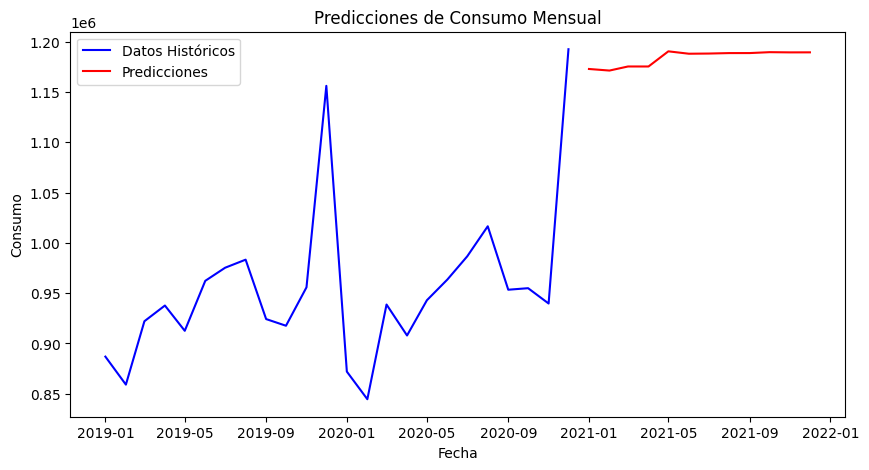

In [58]:
# Graficar los datos históricos
plt.figure(figsize=(10, 5))
plt.plot(consumo_mes.index.to_timestamp(), consumo_mes, label='Datos Históricos', color='blue')

# Graficar las predicciones
plt.plot(predicted_means.index.to_timestamp(), predicted_means, label='Predicciones', color='red')

# Añadir título y etiquetas
plt.title('Predicciones de Consumo Mensual')
plt.xlabel('Fecha')
plt.ylabel('Consumo')
plt.legend()

# Mostrar el gráfico
plt.show()


In [59]:
# Cargar el modelo ARIMA desde el archivo pickle
with open('modelo_arima.pkl', 'rb') as pfile:
    modelo_cargado = pickle.load(pfile)

# Usar el modelo cargado para hacer predicciones u otras operaciones
predicciones = modelo_cargado.get_forecast(steps=12)
print(predicciones.predicted_mean)


2021-01    1.172960e+06
2021-02    1.171394e+06
2021-03    1.175450e+06
2021-04    1.175443e+06
2021-05    1.190511e+06
2021-06    1.188131e+06
2021-07    1.188309e+06
2021-08    1.188768e+06
2021-09    1.188785e+06
2021-10    1.189679e+06
2021-11    1.189470e+06
2021-12    1.189504e+06
Freq: M, Name: predicted_mean, dtype: float64


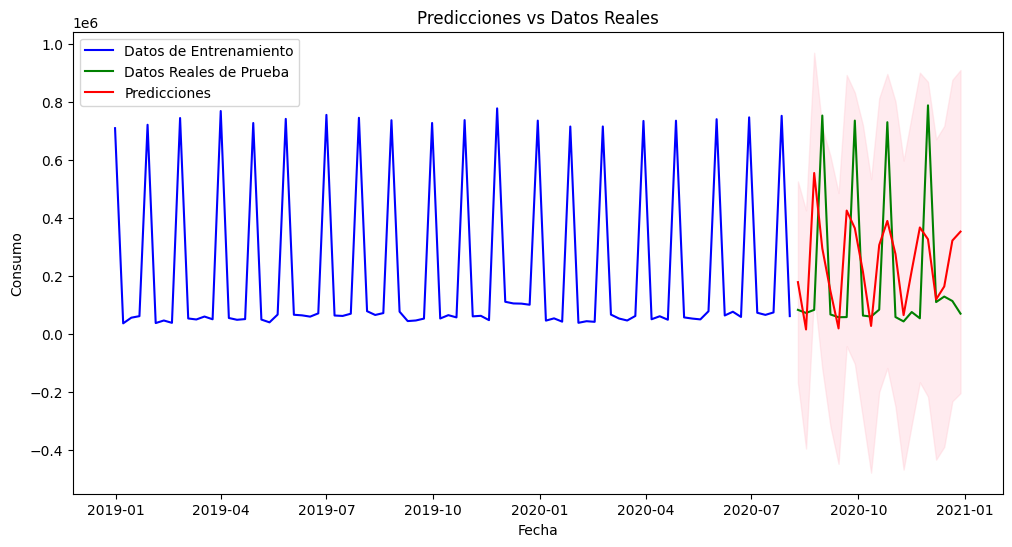

In [60]:
# Cargar y preparar los datos
data = pd.read_csv('new2.csv')
data['transaction_date'] = pd.to_datetime(data['transaction_date'])
data['month'] = data['transaction_date'].dt.to_period('W')
consumo_mes = data.groupby('month')['amount'].sum()

# Dividir los datos en entrenamiento y prueba
split_point = int(len(consumo_mes) * 0.8)  # 80% para entrenamiento, 20% para prueba
train, test = consumo_mes[:split_point], consumo_mes[split_point:]

# Ajustar el modelo ARIMA con los datos de entrenamiento
modelo_arima = ARIMA(train, order=(5,1,0))
resultado = modelo_arima.fit()

# Predicciones
predicciones = resultado.get_forecast(steps=len(test))
predicted_means = predicciones.predicted_mean
conf_int = predicciones.conf_int()  

# Gráfico de los datos de entrenamiento, prueba y predicciones
plt.figure(figsize=(12, 6))
plt.plot(train.index.to_timestamp(), train, label='Datos de Entrenamiento', color='blue')
plt.plot(test.index.to_timestamp(), test, label='Datos Reales de Prueba', color='green')
plt.plot(predicted_means.index.to_timestamp(), predicted_means, label='Predicciones', color='red')
plt.fill_between(predicted_means.index.to_timestamp(), conf_int.iloc[:, 0], conf_int.iloc[:, 1], color='pink', alpha=0.3)
plt.title('Predicciones vs Datos Reales')
plt.xlabel('Fecha')
plt.ylabel('Consumo')
plt.legend()
plt.show()


### Arima ahorro

In [108]:
import warnings

warnings.filterwarnings("ignore")
# Cargar y preparar los datos
data = pd.read_csv('new2.csv')
data['transaction_date'] = pd.to_datetime(data['transaction_date'])
data.set_index('transaction_date', inplace=True)
grouped = data.groupby(['cc_num', 'expense_income']).resample('M').sum()['amount']
grouped_unstacked = grouped.unstack(level=1, fill_value=0)
grouped_unstacked['net_savings'] = grouped_unstacked[0] - grouped_unstacked[1]

# Diccionario para almacenar modelos
modelos_arima = {}

# Ajustar un modelo ARIMA por cada cc_num y almacenar en el diccionario
for cc_num, group in grouped_unstacked.groupby(level=0):
    net_savings = group['net_savings'].dropna()
    if len(net_savings) > 12:  # Asegúrate de tener suficientes puntos de datos
        model_arima = ARIMA(net_savings, order=(1,1,1))
        results_arima = model_arima.fit()
        modelos_arima[cc_num] = results_arima

# Guardar todos los modelos en un archivo pickle
with open('modelos_arima_ahorro.pkl', 'wb') as f:
    pickle.dump(modelos_arima, f)

# Función para cargar y hacer predicciones
def predecir_ahorros(cc_num, steps=5):
    with open('modelos_arima_ahorro.pkl', 'rb') as f:
        modelos = pickle.load(f)
    modelo = modelos[cc_num]
    pred = modelo.get_forecast(steps=steps)
    return pred.predicted_mean.round(2)

# Ejemplo de uso
cc_num_ejemplo = 30270432095985
try:
    predicciones = predecir_ahorros(cc_num_ejemplo)
    print(f"Predicciones de Ahorros para {cc_num_ejemplo}: {predicciones}")
except Exception as e:
    print(f"Error: {e}")


Predicciones de Ahorros para 30270432095985: 24    15008.53
25    15943.93
26    16131.99
27    16169.79
28    16177.39
Name: predicted_mean, dtype: float64
